
## Neural ODE: Project for ECE 50024
#### Zhou, Runwei

In [ ]:
# import package
! pip install torchdiffeq
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from scipy.integrate import solve_ivp
from torchvision import datasets, transforms
from torchdiffeq import odeint
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0, 0.5, 'y')

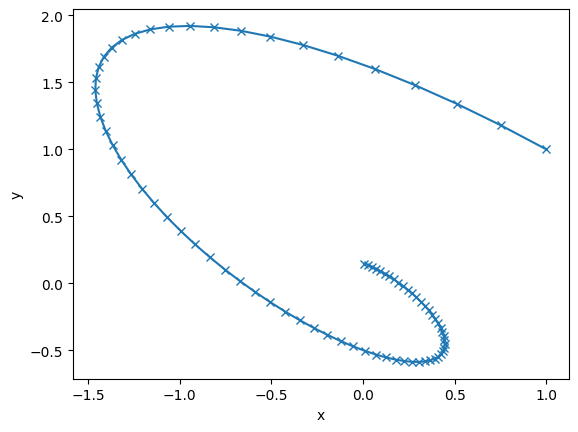

In [ ]:
# ODE solver
def exponential_decay(t, z0):
  return np.exp(-z0*t)

def Spiral(t, z0):
  return torch.mm(torch.tensor([[-1., -1.], [1., 0.5]]), z0)

def ODE_solver(z0, t0, t1, step, f, getfull=False): 
  time_instance = torch.tensor(np.linspace(t0, t1, step))
  sol = odeint(f, z0, time_instance)
  # print(sol)
  if getfull == True:
    return sol[:,:]
  else:
    return sol[-1,:]

# Plot sprial function
time_instance = torch.tensor(np.linspace(0, 10, 4*20))
result_ref = ODE_solver(torch.tensor([[1.],[1.]]), 0., 10., 4*20, Spiral, getfull=True)
# result_ref = result_ref + torch.randn_like(result_ref) * 0.1
plt.plot(result_ref[:, 0], result_ref[:, 1], '-x')
plt.xlabel("x")
plt.ylabel("y")

In [ ]:
class MySpiralData(Dataset):
    def __init__(self):
        self.time_instance = torch.unsqueeze(torch.linspace(0.,10., 4*10),dim=1)
        self.result = ODE_solver(torch.tensor([[1.],[1.]]), 0., 10., 4*10, Spiral, getfull=True)
        self.result = self.result + torch.randn_like(self.result) * 0.01
    def __len__(self):
        return len(self.result)

    def __getitem__(self, idx):
        return self.result[idx,:].flatten(), torch.tensor([self.time_instance[idx]])

train_dataset = MySpiralData()
point, time = train_dataset[23]
print(point)
print(time)
trainloader = DataLoader(train_dataset, batch_size=1,shuffle=True)

class ODEFunction(nn.Module):
    def __init__(self):
        super(ODEFunction,self).__init__()
        self.hidden1 = nn.Linear(2,8)
        self.hidden2 = nn.Linear(4,2)
        self.predict = nn.Linear(8,4)
    def forward(self, t, input, isgrad=False):
        out = torch.relu(self.hidden1(input))
        out = self.predict(out)
        out = self.hidden2(out)
        if isgrad == False:
          return out
        else:
          dLdz = torch.autograd.grad(out, )

class NeuralODE(nn.Module):
    def __init__(self):
        super(NeuralODE, self).__init__()
        self.ode = ODEFunction()
        self.div = 0.1
    def forward(self, x):
        if x[0] != 0.:
          t = torch.linspace(0, x[0], math.ceil(x[0]/self.div))
          y = odeint(self.ode, torch.tensor([[1. ,1.]]), t)  
          # y = odeint(self.ode, torch.randn(1, 2)/2, t)     
          return y[-1,:]
        else:
          return torch.tensor([[1.],[1.]]).flatten()
    
    def backward(self, grad_output):
        with torch.no_grad():
            t = self.integration_time[1]
            x = self.saved_tensors[0]
            z0 = self.saved_tensors[1]
            z1 = self.saved_tensors[2]
            v = grad_output

            for i in range(len(self.integration_time) - 1, 0, -1):
                ti = self.integration_time[i - 1]
                f = self.odefunc(ti, x)
                x = odeint(self.odefunc, x, torch.tensor([ti, t]))[0].detach()
                z0, z1 = z1, x
                v = torch.matmul(f.transpose(-2, -1), v)
                v = torch.autograd.grad(outputs=z1, inputs=(z0, t, v), grad_outputs=v,
                                        only_inputs=True, retain_graph=True)[0]
                t = ti

            f = self.odefunc(self.integration_time[0], x)
            v = torch.matmul(f.transpose(-2, -1), v)

        return v         


tensor([ 0.2316, -0.5841])
tensor([5.8974])


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.ode = NeuralODE()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(2, 2)

    def forward(self, x):
        y = self.ode(x)
        # y = torch.relu(self.fc1(y))
        # y = torch.relu(self.fc2(y))
        y = self.fc3(y).flatten()
        return y
myNet = Net()

In [ ]:
optimizer = torch.optim.Adam(myNet.parameters(),lr = 0.001)
loss_func = torch.nn.MSELoss()

tensor(0.0584, grad_fn=<MseLossBackward0>)
[tensor([0.7279, 1.0389], grad_fn=<AddBackward0>), tensor([0.4637, 1.1395], grad_fn=<ReshapeAliasBackward0>), tensor([0.2382, 1.1762], grad_fn=<ReshapeAliasBackward0>), tensor([0.0602, 1.1442], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0797,  1.0789], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1887,  0.9975], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2721,  0.9044], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3343,  0.8027], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3791,  0.6950], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4088,  0.5833], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4111,  0.4685], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3875,  0.3539], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3521,  0.2450], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3102,  0.1434], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2593,  0.0446], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1972, -0.0552], grad_fn=<ReshapeAliasBackward0>

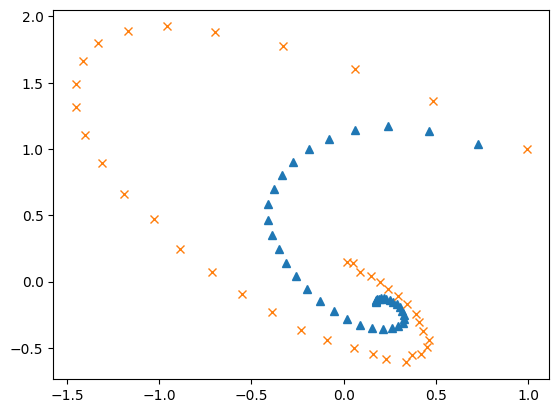

tensor(0.0317, grad_fn=<MseLossBackward0>)
[tensor([0.7212, 1.0598], grad_fn=<AddBackward0>), tensor([0.4466, 1.2015], grad_fn=<ReshapeAliasBackward0>), tensor([0.2036, 1.2682], grad_fn=<ReshapeAliasBackward0>), tensor([0.0065, 1.2585], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1515,  1.2100], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2771,  1.1414], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3755,  1.0579], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4511,  0.9629], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5075,  0.8593], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5477,  0.7492], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5706,  0.6340], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5632,  0.5144], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5382,  0.3974], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5034,  0.2860], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4614,  0.1809], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4139,  0.0822], grad_fn=<ReshapeAliasBackward0>

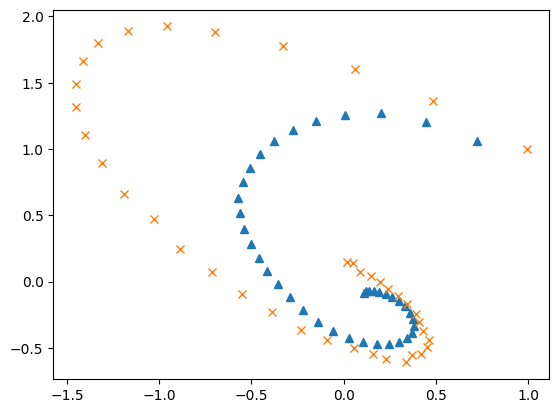

tensor(0.0126, grad_fn=<MseLossBackward0>)
[tensor([0.7088, 1.0767], grad_fn=<AddBackward0>), tensor([0.4318, 1.2541], grad_fn=<ReshapeAliasBackward0>), tensor([0.1750, 1.3562], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0447,  1.3757], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2273,  1.3497], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3769,  1.2984], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4972,  1.2278], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5924,  1.1416], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6656,  1.0429], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7198,  0.9341], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7574,  0.8174], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7672,  0.6924], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7503,  0.5647], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7193,  0.4409], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6770,  0.3217], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6257,  0.2079], grad_fn=<ReshapeAliasBackward

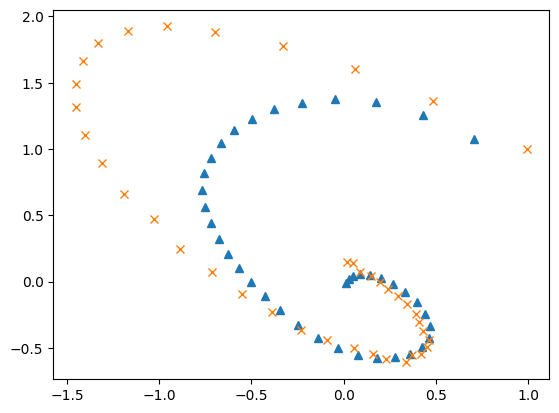

tensor(0.0138, grad_fn=<MseLossBackward0>)
[tensor([0.6939, 1.0931], grad_fn=<AddBackward0>), tensor([0.4044, 1.3129], grad_fn=<ReshapeAliasBackward0>), tensor([0.1259, 1.4517], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1207,  1.4974], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3304,  1.4915], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5048,  1.4544], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6471,  1.3931], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7608,  1.3117], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8491,  1.2133], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9148,  1.1011], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9603,  0.9773], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9755,  0.8413], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9573,  0.6986], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9210,  0.5581], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8697,  0.4210], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8059,  0.2883], grad_fn=<ReshapeAliasBackward

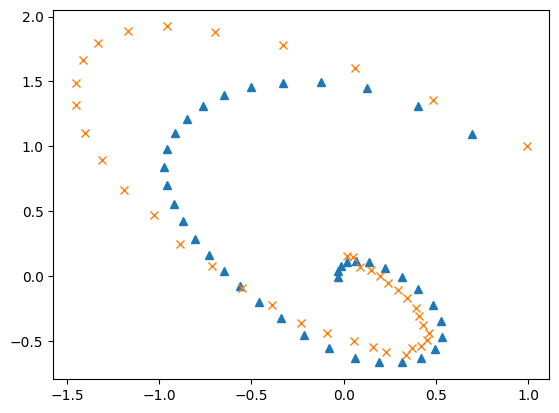

tensor(0.0193, grad_fn=<MseLossBackward0>)
[tensor([0.6801, 1.1055], grad_fn=<AddBackward0>), tensor([0.3608, 1.3646], grad_fn=<ReshapeAliasBackward0>), tensor([0.0534, 1.5306], grad_fn=<ReshapeAliasBackward0>), tensor([-0.2179,  1.5921], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4487,  1.5993], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6407,  1.5708], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7971,  1.5138], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9214,  1.4327], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0168,  1.3312], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0861,  1.2127], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1311,  1.0795], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1335,  0.9290], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1016,  0.7715], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0503,  0.6160], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9830,  0.4639], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9022,  0.3163], grad_fn=<ReshapeAliasBackward

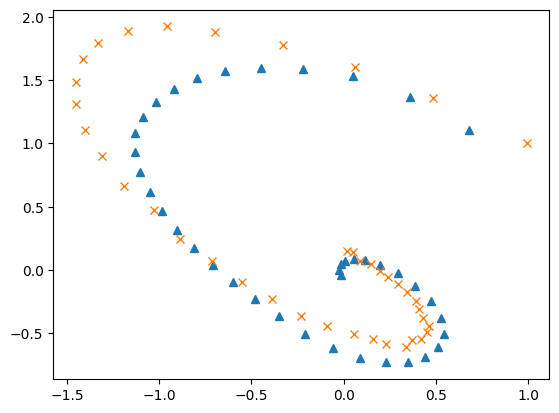

tensor(0.0226, grad_fn=<MseLossBackward0>)
[tensor([0.6707, 1.1132], grad_fn=<AddBackward0>), tensor([0.3172, 1.4035], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0161,  1.5866], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3045,  1.6576], grad_fn=<ReshapeAliasBackward0>), tensor([-0.5484,  1.6732], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7505,  1.6500], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9139,  1.5951], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0423,  1.5131], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1391,  1.4080], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2070,  1.2834], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2423,  1.1404], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2251,  0.9767], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1747,  0.8069], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1054,  0.6398], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0207,  0.4770], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9236,  0.3197], grad_fn=<ReshapeAliasBackwa

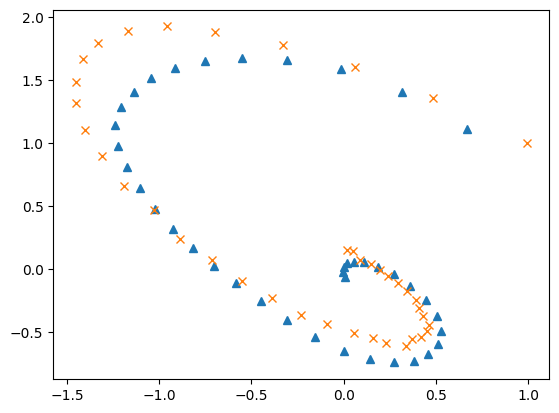

tensor(0.0248, grad_fn=<MseLossBackward0>)
[tensor([0.6665, 1.1178], grad_fn=<AddBackward0>), tensor([0.2871, 1.4309], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0645,  1.6266], grad_fn=<ReshapeAliasBackward0>), tensor([-0.3648,  1.7063], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6180,  1.7293], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8272,  1.7114], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9958,  1.6593], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1272,  1.5778], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2248,  1.4712], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2914,  1.3432], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3153,  1.1924], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2832,  1.0194], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2176,  0.8399], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1341,  0.6641], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0362,  0.4933], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9271,  0.3290], grad_fn=<ReshapeAliasBackwa

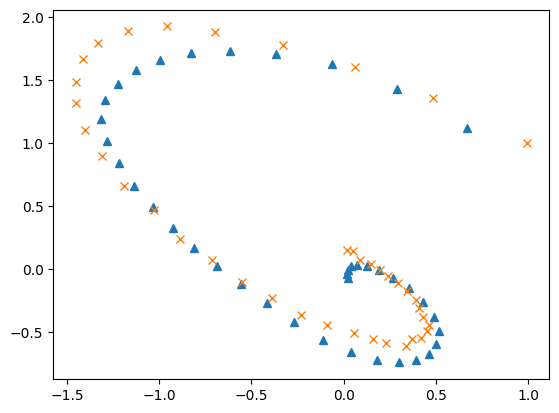

tensor(0.0254, grad_fn=<MseLossBackward0>)
[tensor([0.6666, 1.1202], grad_fn=<AddBackward0>), tensor([0.2691, 1.4485], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0948,  1.6526], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4033,  1.7390], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6630,  1.7677], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8773,  1.7538], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0493,  1.7039], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1825,  1.6229], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2802,  1.5151], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3451,  1.3843], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3570,  1.2267], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3129,  1.0468], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2347,  0.8601], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1398,  0.6779], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0319,  0.5017], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9141,  0.3330], grad_fn=<ReshapeAliasBackwa

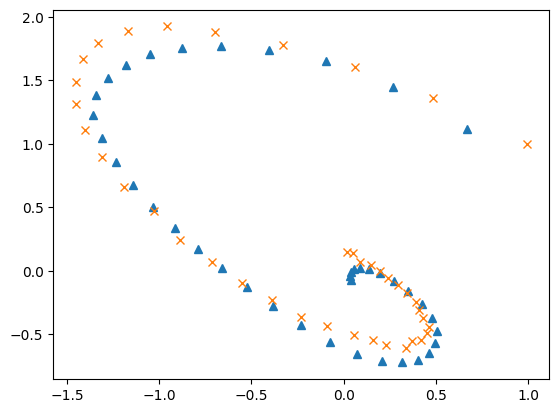

tensor(0.0255, grad_fn=<MseLossBackward0>)
[tensor([0.6700, 1.1213], grad_fn=<AddBackward0>), tensor([0.2611, 1.4592], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1109,  1.6694], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4253,  1.7613], grad_fn=<ReshapeAliasBackward0>), tensor([-0.6902,  1.7949], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9086,  1.7845], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0838,  1.7368], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2190,  1.6568], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3177,  1.5488], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3805,  1.4160], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3841,  1.2540], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3318,  1.0693], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2446,  0.8772], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1417,  0.6903], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0269,  0.5103], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9033,  0.3384], grad_fn=<ReshapeAliasBackwa

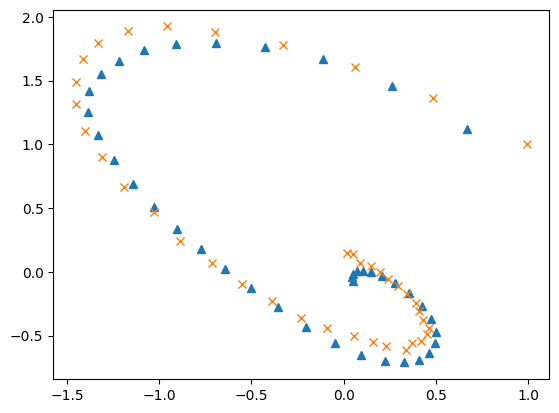

tensor(0.0249, grad_fn=<MseLossBackward0>)
[tensor([0.6758, 1.1215], grad_fn=<AddBackward0>), tensor([0.2600, 1.4649], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1172,  1.6791], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4359,  1.7750], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7048,  1.8119], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9266,  1.8041], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1046,  1.7581], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2417,  1.6788], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3414,  1.5706], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4017,  1.4358], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3989,  1.2701], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3405,  1.0821], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2466,  0.8861], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1378,  0.6961], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0180,  0.5136], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8905,  0.3399], grad_fn=<ReshapeAliasBackwa

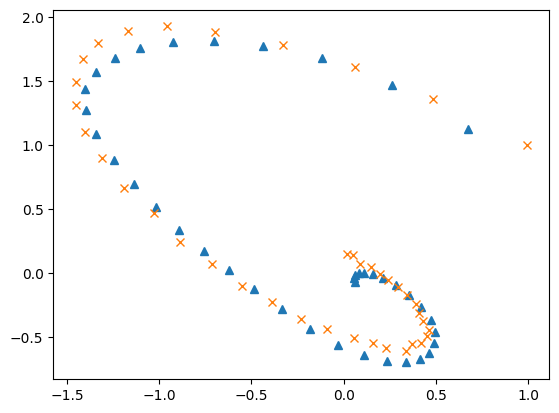

tensor(0.0243, grad_fn=<MseLossBackward0>)
[tensor([0.6833, 1.1210], grad_fn=<AddBackward0>), tensor([0.2638, 1.4677], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1171,  1.6849], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4394,  1.7841], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7120,  1.8240], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9373,  1.8185], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1182,  1.7742], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2578,  1.6958], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3592,  1.5878], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4179,  1.4515], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4109,  1.2833], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3485,  1.0928], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2498,  0.8938], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1367,  0.7012], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0135,  0.5167], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8832,  0.3415], grad_fn=<ReshapeAliasBackwa

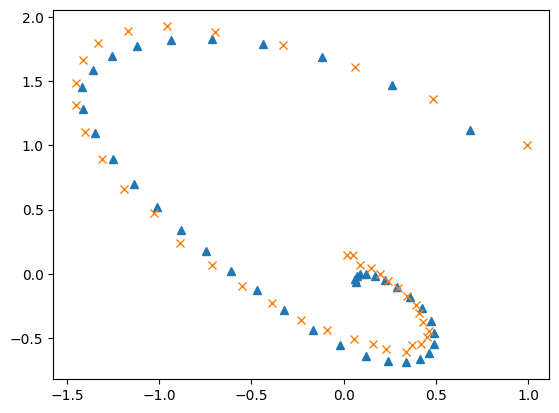

tensor(0.0233, grad_fn=<MseLossBackward0>)
[tensor([0.6918, 1.1202], grad_fn=<AddBackward0>), tensor([0.2705, 1.4682], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1127,  1.6874], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4379,  1.7889], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7138,  1.8311], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9422,  1.8274], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1260,  1.7843], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2680,  1.7064], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3713,  1.5984], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4283,  1.4605], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4181,  1.2903], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3524,  1.0976], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2501,  0.8964], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1339,  0.7020], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0081,  0.5163], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8758,  0.3403], grad_fn=<ReshapeAliasBackwa

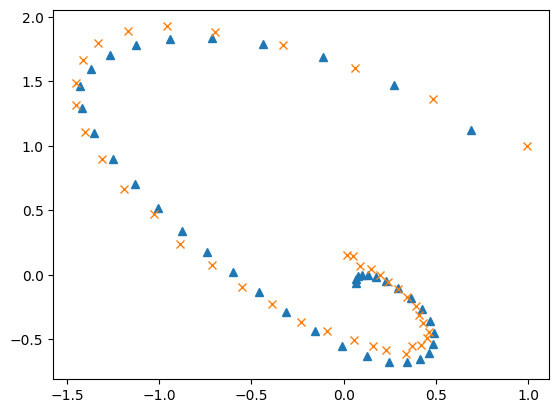

tensor(0.0224, grad_fn=<MseLossBackward0>)
[tensor([0.7009, 1.1190], grad_fn=<AddBackward0>), tensor([0.2791, 1.4677], grad_fn=<ReshapeAliasBackward0>), tensor([-0.1057,  1.6886], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4337,  1.7923], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7129,  1.8367], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9448,  1.8348], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1318,  1.7929], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2767,  1.7159], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3823,  1.6080], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4384,  1.4689], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4261,  1.2969], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3581,  1.1025], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2532,  0.8994], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1346,  0.7033], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0067,  0.5162], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8729,  0.3394], grad_fn=<ReshapeAliasBackwa

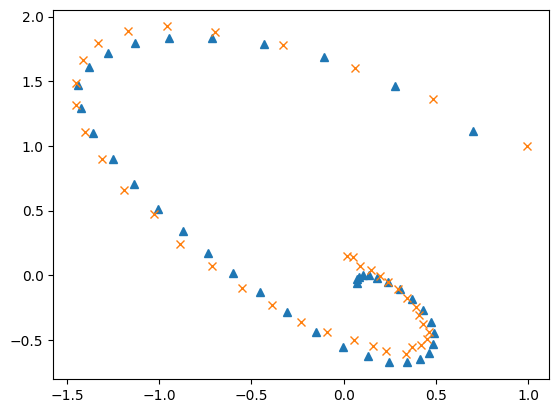

tensor(0.0213, grad_fn=<MseLossBackward0>)
[tensor([0.7103, 1.1177], grad_fn=<AddBackward0>), tensor([0.2888, 1.4661], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0972,  1.6882], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4276,  1.7935], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7098,  1.8395], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9447,  1.8388], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1346,  1.7978], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2821,  1.7211], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3900,  1.6132], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4447,  1.4725], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4304,  1.2988], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3603,  1.1028], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2532,  0.8981], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1327,  0.7009], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0034,  0.5131], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8684,  0.3359], grad_fn=<ReshapeAliasBackwa

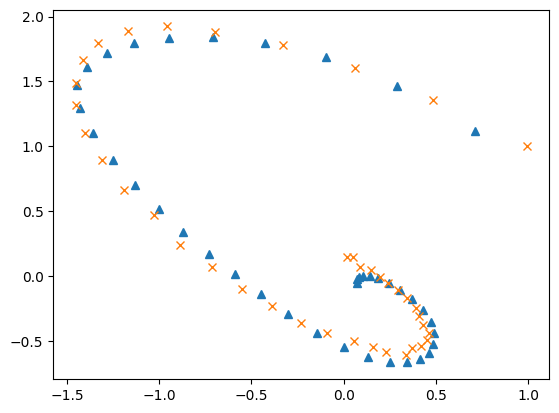

tensor(0.0205, grad_fn=<MseLossBackward0>)
[tensor([0.7198, 1.1160], grad_fn=<AddBackward0>), tensor([0.2992, 1.4644], grad_fn=<ReshapeAliasBackward0>), tensor([-0.0879,  1.6878], grad_fn=<ReshapeAliasBackward0>), tensor([-0.4206,  1.7950], grad_fn=<ReshapeAliasBackward0>), tensor([-0.7060,  1.8429], grad_fn=<ReshapeAliasBackward0>), tensor([-0.9443,  1.8437], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1375,  1.8038], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2881,  1.7279], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3987,  1.6202], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4528,  1.4784], grad_fn=<ReshapeAliasBackward0>), tensor([-1.4373,  1.3032], grad_fn=<ReshapeAliasBackward0>), tensor([-1.3659,  1.1057], grad_fn=<ReshapeAliasBackward0>), tensor([-1.2570,  0.8993], grad_fn=<ReshapeAliasBackward0>), tensor([-1.1347,  0.7007], grad_fn=<ReshapeAliasBackward0>), tensor([-1.0040,  0.5118], grad_fn=<ReshapeAliasBackward0>), tensor([-0.8679,  0.3339], grad_fn=<ReshapeAliasBackwa

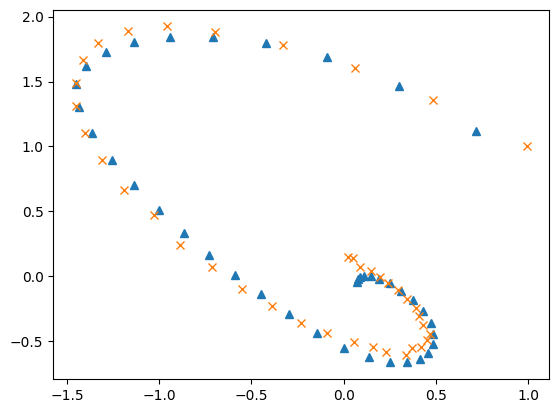

In [ ]:
epoch = 15
# time_instance = torch.tensor(np.linspace(0, 1, 51))
result = []
ref = []
for ii in range(epoch):
  for point, time in train_dataset:
    # print(point)
    # print(time)
    prediction = myNet(time)
    # print(prediction)
    # print(point)
    loss = loss_func(prediction,point)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    result.append(prediction)
    ref.append(point)
    # print(result)

  if ii%1==0:
    print(loss)
    print(result)
    result = torch.cat(result)
    result = torch.reshape(result, (-1, 2))   
    ref = torch.cat(ref)
    ref = torch.reshape(ref, (-1, 2))
    # print(result[:][:][-1])
    # print(result[:,0])
    # print(result[:,0].flatten())
    plt.cla()
    plt.plot(result[:,0].detach().numpy(), result[:,1].detach().numpy(), '^')  
    plt.plot(ref[:,0].detach().numpy(), ref[:,1].detach().numpy(), 'x')
    plt.savefig("/content/content/result" + str(15+ii) + '.pdf')
    plt.show()
  result = []
  ref = []